# Data Science Project Workflow

## Project Overview
- **Objective**: Define the problem and goals of the project.
- **Milestones**: Data Collection, Exploration, Preprocessing, Advanced Analysis, Model Development, Deployment, and Final Documentation.

---

## Domain and Research Questions

### Domain of the Project
Non-profit and social impact

### Research Questions to be Answered
1. **Question 1**: Does the state affect the size of donation? 
2. **Question 2**: Is there correlation between Total revenue and program expenditure?
3. **Question 3**: Which types of non-profits receive the most donations?

---

# Team Information

## Student Information
- **Name**: Mohamed Assal
- **Email**: ma2201152@tkh.edu.eg  
- **Role**: Data Science Student  
- **Institution**: TKH Coventry

## Additional Information
- **Project Timeline**: [Insert Start Date - End Date]  
- **Tools Used**: [Insert List of Tools or Frameworks, e.g., Python, SQLite, Pandas, etc.]  
- **Advisor/Instructor**: [Insert Advisor/Instructor Name, if applicable]  
- **Contact for Inquiries**: [Insert Email or Point of Contact]

---

# Milestone 1: Data Collection, Exploration, and Preprocessing

## Data Collection
- Acquire a dataset from reliable sources (e.g., Kaggle, UCI Repository, or APIs).
- **Scraping Data**:
  - Increase dataset size through web scraping or APIs (e.g., Selenium, BeautifulSoup).
  - Explore public repositories or other accessible sources for additional data.

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re

def scrape_policybee_charities(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    pattern = re.compile(r"^(.+?)\s+\((£?[\d.,]+[mb]n?)\)")
    results = []

    for li in soup.find_all("li"):
        text = li.get_text(strip=True)
        match = pattern.match(text)
        if match:
            name, amount = match.groups()
            results.append({
                "name": name,
                "rev": amount
            })

    return results

url = "https://www.policybee.co.uk/blog/uk-charity-statistics"
charities = scrape_policybee_charities(url)
for c in charities:
    print(c)
    df_scraped = pd.DataFrame(charities)

def scrape_top_10_charities(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    charities = []

    table = soup.find("table")
    if table:
        rows = table.find_all("tr")[1:] 
        for row in rows:
            cols = row.find_all("td")
            if len(cols) >= 2:
                name = cols[0].get_text(strip=True)
                expenditure = cols[1].get_text(strip=True)
                charities.append({
                    "name": name,
                    "charitable_expenditure": expenditure
                })

    return charities


url = "https://register-of-charities.charitycommission.gov.uk/en/sector-data/top-10-charities"
top_charities = scrape_top_10_charities(url)
print(top_charities)
df_scraped_2 = pd.DataFrame(top_charities)
df_scraped['name'] = df_scraped['name'].str.strip().str.lower()
df_scraped_2['name'] = df_scraped_2['name'].str.strip().str.lower()

def clean_financial_column(value):

    if isinstance(value, str):

        value = value.replace('£', '').replace(',', '').strip()

        if 'bn' in str(value):
            return float(value.replace('bn', '').strip()) * 1e9
        elif 'm' in str(value):
            return float(value.replace('m', '').strip()) * 1e6
        else:
            try:
                return float(value)
            except ValueError:
                return None  
    else:
        return value 
df_scraped['name'] = df_scraped['name'].str.replace("[’']", "", regex=True)
df_scraped_2['name'] = df_scraped_2['name'].str.replace("[’']", "", regex=True)
df_combined_scraped = pd.merge(df_scraped, df_scraped_2, on="name", how="outer")
df_combined_scraped['rev'] = df_combined_scraped['rev'].apply(clean_financial_column)
df_combined_scraped['charitable_expenditure'] = df_combined_scraped['charitable_expenditure'].apply(clean_financial_column)
exchange_rate = 1.25
df_combined_scraped['rev'] = df_combined_scraped['rev'] *exchange_rate
df_combined_scraped['charitable_expenditure'] = df_combined_scraped['charitable_expenditure'] *exchange_rate

df_combined_scraped = df_combined_scraped.groupby('name', as_index=False).agg({
    'rev': 'first', 
    'charitable_expenditure': 'first'  
})

df_combined_scraped.to_csv('charities_combined.csv', index=False)
# df_final = pd.merge(df_combined_scraped, df_scraped_2[['name', 'charitable_expenditure']], on="name", how="left")


{'name': 'Nuffield Health', 'rev': '1.36bn'}
{'name': 'Save the Children International', 'rev': '1.22bn'}
{'name': 'The Charities Aid Foundation', 'rev': '1.15bn'}
{'name': 'The British Council', 'rev': '£873m'}
{'name': 'The Arts Council of England', 'rev': '£803m'}
{'name': 'United Learning Ltd', 'rev': '£735m'}
{'name': 'The National Trust', 'rev': '£723m'}
{'name': 'Cancer Research UK', 'rev': '£684m'}
{'name': 'Cardiff University', 'rev': '£636m'}
{'name': 'Lloyd’s Register Foundation', 'rev': '£560m'}
[{'name': 'NUFFIELD HEALTH', 'charitable_expenditure': '£1,358,100,000'}, {'name': 'SAVE THE CHILDREN INTERNATIONAL', 'charitable_expenditure': '£1,216,342,610'}, {'name': 'THE CHARITIES AID FOUNDATION', 'charitable_expenditure': '£1,194,823,000'}, {'name': 'THE BRITISH COUNCIL', 'charitable_expenditure': '£989,335,930'}, {'name': 'THE ARTS COUNCIL OF ENGLAND', 'charitable_expenditure': '£803,065,402'}, {'name': 'United Learning LTD', 'charitable_expenditure': '£735,585,000'}, {'nam

In [ ]:
import pandas as pd


merged_df = pd.read_csv("CLEAN_charity_data.csv", dtype={"ein": str})

merged_df.columns = merged_df.columns.str.lower()


merged_df = merged_df.rename(columns={'tot_rev' : 'total_rev', 'program_exp':'prog_exp'})

merged_df = pd.merge(merged_df, df_combined_scraped, on="name", how="outer")
merged_df['total_rev'] = merged_df['total_rev'].fillna(merged_df['rev'])
merged_df.drop(['rev'], axis=1,inplace=True )
merged_df['prog_exp'] = merged_df['prog_exp'].fillna(merged_df['charitable_expenditure'])
merged_df.drop(['charitable_expenditure'], axis=1, inplace=True)


print(f"Duplicate EINs: {merged_df['ein'].duplicated().sum()}")
merged_df.to_csv("Merged_dataframe.csv")

merged_df.columns
print(merged_df.groupby('state')['total_rev'].describe())



Duplicate EINs: 10
       count          mean           std        min         25%        50%  \
state                                                                        
AK      17.0  3.967403e+06  4.232408e+06   740065.0  1249139.00  2522408.0   
AL      66.0  9.974086e+06  2.127281e+07   382617.0  1543718.75  2818935.0   
AR      31.0  1.030145e+07  2.312983e+07  1027982.0  1786160.00  3262916.0   
AZ     124.0  1.372692e+07  2.833893e+07  -777555.0  2164337.50  4590023.0   
CA     992.0  1.568740e+07  4.768302e+07   242414.0  2178442.50  4427727.0   
CO     246.0  1.499290e+07  6.315897e+07   406959.0  1987751.50  3506606.5   
CT     130.0  3.187724e+07  2.182161e+08   558063.0  1966930.00  3551425.5   
DC     447.0  2.446968e+07  1.736779e+08   186176.0  2191353.50  5136839.0   
DE      23.0  6.636480e+06  6.513152e+06   672343.0  2133161.50  3316507.0   
FL     423.0  1.589539e+07  7.224246e+07    71653.0  2076141.50  4286212.0   
GA     207.0  2.282224e+07  8.809482e+07    4

## Dataset Description
- Create a table to explain:
  - **Column Names**
  - **Data Types**
  - **Descriptions**
  - **Potential Use in Analysis**

In [3]:
merged_df.columns
merged_df.dtypes
data = {
    "Column Name": ['ein', 'city', 'group', 'asset_amt', 'ascore', 'category', 'tot_exp', 'admin_exp_p', 'fund_eff', 
                    'fund_exp_p', 'program_exp_p', 'fscore', 'score', 'subcategory', 'fund_exp', 'admin_exp', 'state', 'name', 'tot_income', 
                    'prog_exp', 'total_rev'],
    "Data Type": ['Float64', 'object', 'float64', 'float64', 'float64', 'object', 'float64', 'float64', 'float64', 
                  'float64', 'float64', 'float64', 'object', 'float64',  'float64', 'float64', 'object', 'object', 'float64', 'float64', 'float64'],
    "Description": ['Employer Identification Number (EIN), unique identifier for the organization.',
                    'The city where the organization is located.',
                    'Classification or group code for the organization.',
                    'The total value of the assets owned by the organization.',
                    'A score indicating the financial health or status of the organization.',
                    'Category of the organization (e.g., Health, Education).',
                    'Total expenditure by the organization(prog, admin, fund).',
                    'Administrative expenses as a percentage of total expenditures.',
                    'Efficiency of the organizations spending.',
                    'The percentage of funds spent on the programs.',
                    'Percentage of total spending allocated to programs.',
                    'Financial score indicating the organizations financial stability.',
                    'Overall financial score or rating for the organization.',
                    'Subcategory or niche the organization falls under.',
                    'Total fund expenditure of the organization.',
                    'Administrative expenses incurred by the organization.',
                    'State in which the organization is registered.',
                    'The name of the organization.',
                    'Total income generated by the organization.',
                    'Program expenditure by the organization.',
                    'Total revenue, including donations and grants, generated by the organization.']
}
df_descp = pd.DataFrame(data)
print(df_descp)





      Column Name Data Type                                        Description
0             ein   Float64  Employer Identification Number (EIN), unique i...
1            city    object        The city where the organization is located.
2           group   float64  Classification or group code for the organizat...
3       asset_amt   float64  The total value of the assets owned by the org...
4          ascore   float64  A score indicating the financial health or sta...
5        category    object  Category of the organization (e.g., Health, Ed...
6         tot_exp   float64  Total expenditure by the organization(prog, ad...
7     admin_exp_p   float64  Administrative expenses as a percentage of tot...
8        fund_eff   float64          Efficiency of the organizations spending.
9      fund_exp_p   float64     The percentage of funds spent on the programs.
10  program_exp_p   float64  Percentage of total spending allocated to prog...
11         fscore   float64  Financial score indicat

## Data Exploration
- Summary statistics (mean, median, variance).
- Identify missing values, duplicates, and outliers.
- Data distribution visualizations: histograms, box plots, scatter plots.

In [ ]:
import plotly.express as px
import numpy as np
merged_df['log_prog_exp'] = np.log1p(merged_df['prog_exp'])
columns_to_analyze = ['prog_exp', 'total_rev', 'log_prog_exp'] 
original_mean = merged_df[columns_to_analyze].mean()
original_median = merged_df[columns_to_analyze].median()
original_variance = merged_df[columns_to_analyze].var()
summary_stats = pd.DataFrame({
    'Original Mean': original_mean,
    'Original Median': original_median,
    'Original Variance': original_variance,
    })
print(summary_stats)


test_box_prog = px.box(merged_df, y="prog_exp")
test_box_prog.show()
histo_rev = px.histogram(merged_df, x="prog_exp", y="category")
histo_rev.show()

histo_states = px.histogram(merged_df, x= "state", y= "prog_exp")
histo_states.show()

duplicates = merged_df[merged_df.duplicated(subset=['ein'], keep=False)]
print(duplicates[['name', 'ein']])
print(merged_df['prog_exp'].isna().sum())
print(merged_df['total_rev'].isna().sum())



              Original Mean  Original Median  Original Variance
prog_exp       4.387134e+06     2.595619e+06       2.112947e+13
total_rev      6.026603e+06     3.474606e+06       5.164370e+13
log_prog_exp   1.485859e+01     1.476934e+01       8.597281e-01


Empty DataFrame
Columns: [name, ein]
Index: []
0
0
       total_rev      prog_exp  rev_to_prog_exp
0      7471137.0  2.642691e+06         2.827095
8     16810730.0  1.072759e+07         1.567055
11     3416142.0  3.129484e+06         1.091599
13     1997427.0  1.151389e+06         1.734797
23     1138601.0  1.486518e+06         0.765952
...          ...           ...              ...
8374   7731129.0  6.131604e+06         1.260866
8383   5640512.0  5.495075e+06         1.026467
8398   3443525.0  2.622303e+06         1.313168
8400  14306642.0  1.355244e+07         1.055651
8404   2445321.0  2.851551e+06         0.857541

[847 rows x 3 columns]


C:\Users\moham\AppData\Local\Temp\ipykernel_15420\3463384315.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Preprocessing and Feature Engineering
- Handle missing values.
- Remove duplicates and outliers.
- Apply transformations (scaling, encoding, feature interactions).

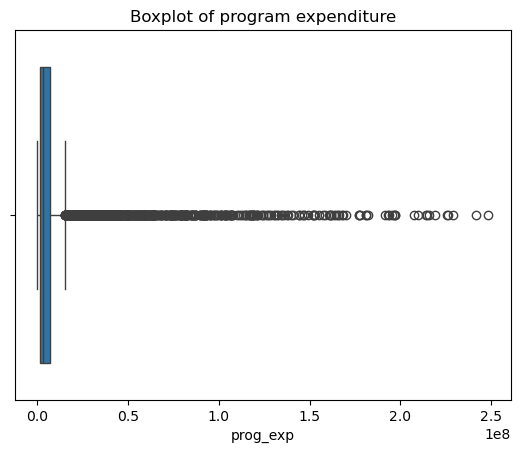

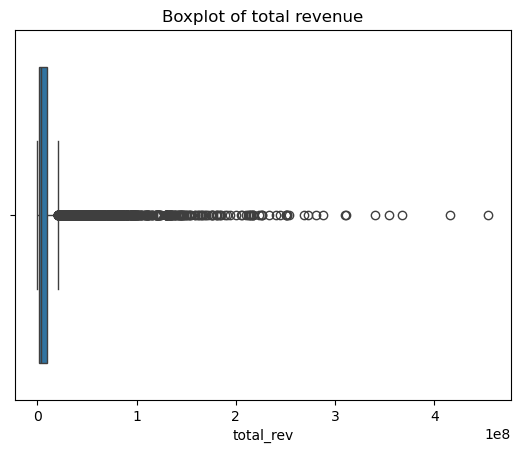

NaN counts:
prog_exp    0
dtype: int64
Negative value counts:
prog_exp    0
dtype: int64
53
['NY' 'HI' 'CA' 'GA' 'AZ' 'FL' 'OR' 'NC' 'OH' 'WI' 'OK' 'WA' 'MA' 'DC'
 'PA' 'VA' 'NM' 'CO' 'MD' 'TX' 'MI' 'MN' 'TN' 'IL' 'ME' 'KY' 'NJ' 'UT'
 'MS' 'MO' 'AL' 'AK' 'KS' 'CT' 'IN' 'WV' 'IA' 'MT' 'SC' 'NV' 'AR' 'RI'
 'NE' 'ID' 'SD' 'DE' 'LA' 'VT' 'WY' 'NH' 'PR' 'VI' 'ND']


In [5]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

merged_df = merged_df.drop_duplicates(subset='ein')


merged_df = merged_df[merged_df['total_rev'] >= 0]

merged_df = merged_df[

    # (merged_df['prog_exp'] >= 50_000) &
    (merged_df['prog_exp'] <= 250_000_000)
]


sns.boxplot(x=merged_df['prog_exp'])
plt.title("Boxplot of program expenditure")
plt.show()

sns.boxplot(x=merged_df['total_rev'])
plt.title("Boxplot of total revenue")
plt.show()





scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_df[['prog_exp', 'total_rev']])
merged_df[['scaled_prog_exp', 'scaled_total_rev']] = scaled_features

merged_df['state_copy'] = merged_df['state'].copy()
merged_df['category_copy'] = merged_df['category'].copy()

merged_df = pd.get_dummies(merged_df, columns=['state_copy', 'category_copy'], drop_first=False)
state_columns = [col for col in merged_df.columns if col.startswith('state_copy_')]

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

merged_df = remove_outliers_iqr(merged_df, 'prog_exp')

merged_df['total_rev'].describe()
print("NaN counts:")
print(merged_df[['prog_exp']].isna().sum())
print("Negative value counts:")
print((merged_df[['prog_exp']] < 0).sum())

print(merged_df['state'].nunique())
print(merged_df['state'].unique())



---

# Milestone 2: Advanced Data Analysis and Feature Engineering

## Statistical Analysis
- Conduct tests such as t-tests, ANOVA, and chi-squared to explore relationships.

In [6]:
from scipy import stats
import numpy as np
import seaborn as sns
import pingouin as pg
groups = [merged_df[merged_df['state'] == state]['prog_exp'].dropna() for state in merged_df['state'].unique()]

groups = [group for group in groups if len(group) > 0]
f_state, p_value = stats.f_oneway(*groups)

print(f"F-Statistic: {f_state}")
print(f"P-value: {p_value}")

welch_raw = pg.welch_anova(dv='prog_exp', between='state', data=merged_df)
print("Welch ANOVA on raw:")
print(welch_raw)

F-Statistic: 2.1038506135471273
P-value: 6.432933712363123e-06
Welch ANOVA on raw:
  Source  ddof1       ddof2         F         p-unc       np2
0  state     52  585.280678  2.710255  7.926415e-09  0.014163


## Feature Engineering
- Create derived features based on domain knowledge.
- Apply transformations such as normalization, log scaling, or polynomial features.

In [7]:
merged_df['prog_exp_to_rev'] = merged_df['prog_exp'] / merged_df['total_rev']
safe_prog_exp = merged_df['prog_exp'].copy()
safe_prog_exp[~((safe_prog_exp > 0) & safe_prog_exp.notna())] = np.nan

safe_total_rev = merged_df['total_rev'].copy()
safe_total_rev[~((safe_total_rev > 0) & safe_total_rev.notna())] = np.nan
merged_df['log_prog_exp'] = np.log1p(safe_prog_exp)
merged_df['log_total_rev'] = np.log1p(safe_total_rev)

## Data Visualization
- Generate insightful visualizations:
  - Correlation heatmaps, pair plots.
  - Trends and comparisons using bar charts, line charts, and dashboards.

In [8]:
cat_hitso = px.histogram(merged_df, x ='category')
cat_hitso.show()
state_histo = px.histogram(merged_df, x = 'state')
state_histo.show()
exp_rev = px.scatter (merged_df,x = 'tot_exp', y = 'total_rev',
labels={'tot_exp': "Total expenditure", 'tot_rev': "total revenue"},
title="Total exp Vs rev")
exp_rev.show()
state_agg = merged_df.groupby('state', as_index=False)['prog_exp'].mean()
histo_rev = px.bar(state_agg, y="prog_exp", x="state")
histo_rev.update_traces(marker_color='red')
histo_rev.show()
corr_matrix = merged_df[['prog_exp', 'total_rev', 'log_prog_exp', 'log_total_rev']].corr()
fig = px.imshow(corr_matrix, 
                color_continuous_scale='RdBu', 
                title="Correlation Heatmap", 
                labels=dict(x="Features", y="Features"))
fig.show()
px.scatter_matrix(merged_df, dimensions=['prog_exp','total_rev'])




---


# Milestone 3: Machine Learning Model Development and Optimization

## Model Selection
- Choose appropriate models for the problem type (classification, regression, clustering, etc.).


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


model = LinearRegression()
X = merged_df[['total_rev'] + state_columns ]
y = merged_df['prog_exp']
rf = RandomForestRegressor(n_estimators=100, random_state=42)


## Model Training
- Split data into training, validation, and testing sets.
- Address imbalances using techniques like SMOTE or stratified sampling.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Model Evaluation
- Metrics to consider: Accuracy, Precision, Recall, F1-score, RMSE, etc.
- Visual tools: Confusion matrices, ROC curves.

RMSE: 2696456.298582585
Mean Squared Error: 7270876570165.695
R-squared: 0.6624192492602513
RMSE rf: 1941022.8658119296
Mean Squared Error rf : 3767569765604.756
R-squared rf : 0.8250748699055074


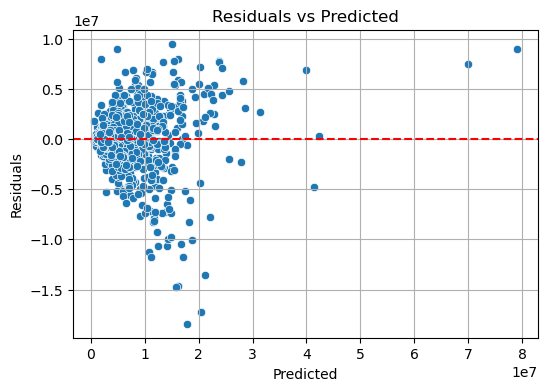

In [19]:
y_pred = model.predict(X_test)  
rf_preds = rf.predict(X_test)

mse_rf= mean_squared_error(y_test, rf_preds)
r2_rf = r2_score(y_test, rf_preds)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_preds))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("RMSE rf:", rmse_rf)
print("Mean Squared Error rf :", mse_rf)
print("R-squared rf :", r2_rf)

residuals = y_test - rf_preds
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')  
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.show() 

## Hyperparameter Tuning
- Techniques: Grid Search, Random Search, or advanced methods like Bayesian Optimization.

In [12]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 300),        
    'max_depth': randint(5, 30),              
    'min_samples_split': randint(2, 10),      
    'min_samples_leaf': randint(1, 5),        
    'max_features': ['sqrt', 'log2', None]         
}
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                    
    cv=5,                         
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error' 
)
random_search.fit(X, y)
print(random_search.best_params_)
print(random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 136}
-0.09827236783461576


## Model Comparison
- Compare multiple models and justify the final model selection.

In [20]:
y_pred = model.predict(X_test)  
rf_preds = rf.predict(X_test)

mse_rf= mean_squared_error(y_test, rf_preds)
r2_rf = r2_score(y_test, rf_preds)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_preds))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("RMSE rf:", rmse_rf)
print("Mean Squared Error rf :", mse_rf)
print("R-squared rf :", r2_rf)

RMSE: 2696456.298582585
Mean Squared Error: 7270876570165.695
R-squared: 0.6624192492602513
RMSE rf: 1941022.8658119296
Mean Squared Error rf : 3767569765604.756
R-squared rf : 0.8250748699055074


## Visualization for Research Questions
- This section will include the visualizations that provide insights for the research questions defined earlier.  
- **Development Steps for Answering the Research Questions**:
  1. During **Exploratory Data Analysis (EDA)**, visualize initial patterns or trends related to the research questions.
  2. During **Model Evaluation**, provide visualizations to interpret model performance with respect to the research questions.
  3. During the **Final Analysis and Reporting**, present polished visualizations that summarize findings for each research question.

- Create the visualizations for each research question you defined, prove it or answer it, then add a markdown cell after each visual to comment and explain how the visual support your research question.

In [30]:
corr_matrix = merged_df[['prog_exp', 'total_rev', 'log_prog_exp', 'log_total_rev']].corr()
fig = px.imshow(corr_matrix, 
                color_continuous_scale='RdBu', 
                title="Correlation Heatmap", 
                labels=dict(x="Features", y="Features"))
fig.show()

histo_rev = px.bar(state_agg, y="prog_exp", x="state")
histo_rev.update_layout(
    yaxis_title="Mean of Program Expenditure",
    xaxis_title="State"
)
histo_rev.update_traces(marker_color='red')
histo_rev.show()

category_agg = merged_df.groupby('category').agg(
    count=('category', 'count'),
    mean_prog_exp=('prog_exp', 'mean')
).reset_index()

fig = px.scatter_3d(
    category_agg,
    x='category',
    y='count',
    z='mean_prog_exp',
    text='category', 
    title='3D Scatter Plot: Category vs Count vs Mean Program Expenditure'
)
fig.update_traces(textfont=dict(size=6))
fig.show()

Fig1: This figure shows a correlation heatmap between program expenditure and total revenue and we can see the number shown is 0.82 so we can conclude that there is a positive correlation between them.

Fig2: This bar graph shows the states and the mean program expenditure for each one and we can see that some states are spiked up such as NY, it has double the mean of some other states so we can conclude that the donation size differs for each state.

Fig3: This figure is a 3d scatter plot showing the different categories in out dataset and the couunt of each one in our dataset and the mean program expenditure for every one this shows us which type gets the most donations. we can see that human services is one of the highest however it also has the highest count at 2100 while some other categries like arts and community developments have a higher expenditure and a less than half the count.


---


# Milestone 4: Deployment and Monitoring

## Deployment
- Deploy the model as a REST API (Flask, FastAPI) or interactive dashboards (Streamlit, Dash).
- Host on cloud platforms (AWS, Azure, GCP) or local servers.

In [21]:
import joblib
joblib.dump(rf, 'model.pkl')


['model.pkl']

## Monitoring
- Set up performance tracking and alert systems for issues.
- Monitor metrics for potential model drift or anomalies.

       total_rev      prog_exp  rev_to_prog_exp
0      7471137.0  2.642691e+06         2.827095
8     16810730.0  1.072759e+07         1.567055
11     3416142.0  3.129484e+06         1.091599
13     1997427.0  1.151389e+06         1.734797
23     1138601.0  1.486518e+06         0.765952
...          ...           ...              ...
8374   7731129.0  6.131604e+06         1.260866
8383   5640512.0  5.495075e+06         1.026467
8398   3443525.0  2.622303e+06         1.313168
8400  14306642.0  1.355244e+07         1.055651
8404   2445321.0  2.851551e+06         0.857541

[847 rows x 3 columns]


C:\Users\moham\AppData\Local\Temp\ipykernel_15420\84322497.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Retraining Strategy
- Plan for periodic retraining with new or updated data.


---


# Milestone 5: Final Documentation and Presentation

## Final Report
- Summarize all project phases, including methodologies and insights.
- Provide actionable recommendations based on findings.

## Final Presentation
- Create a presentation for stakeholders, highlighting key results.
- Include a demo of the deployed application or model.

## Future Improvements
- Suggest areas for enhancement:
  - Incorporating more diverse data.
  - Experimenting with additional algorithms.
  - Optimizing deployment for scalability.

---

# Additional Sections

## Challenges Faced
- Document key challenges encountered during the project lifecycle.

## Lessons Learned
- Reflect on insights and skills gained through the project.

## References
- List resources for datasets, tools, and techniques utilized.

---

# More Sections for Specific Projects

## Ethical Considerations
- Discuss privacy, fairness, or other ethical implications.

## Business Impact
- Highlight how the findings address the original objective.

## Team Contributions
- Acknowledge contributions from team members and collaborators.


---


# Reflection: Data Science Lifecycle Steps and Big Data

Reflect on which steps of the data science lifecycle can and cannot be effectively applied to big data, and justify your answers:

## Steps That Can Be Used with Big Data

Create a list for the steps that can be used with big data with how each step can be used, why is such step applicable and an example tool used for such step in big data world.

Include tools, methods, or technologies that make these steps scalable.

## Steps That Are Challenging with Big Data

Create a list for the steps that are challenging with big data with the solution for the challenge, why is such step challenging and an example tool used for such step in big data world.

Explain why these steps are difficult and suggest potential solutions.

## Recommendations for Big Data Projects

Create a list for the recommendations you have for other data scientists willing to take your project with a big data approach.

---